decrease of log likelihood: 4019.4299
decrease of log likelihood: 17.1372
decrease of log likelihood: 5.2259
decrease of log likelihood: 1.8730
decrease of log likelihood: 1.0570
decrease of log likelihood: 0.8002
decrease of log likelihood: 0.6561
decrease of log likelihood: 0.5352
decrease of log likelihood: 0.4267
decrease of log likelihood: 0.3341
decrease of log likelihood: 0.2597
decrease of log likelihood: 0.2027
decrease of log likelihood: 0.1604
decrease of log likelihood: 0.1299
decrease of log likelihood: 0.1084
decrease of log likelihood: 0.0936
decrease of log likelihood: 0.0835
decrease of log likelihood: 0.0766
decrease of log likelihood: 0.0720
decrease of log likelihood: 0.0688
decrease of log likelihood: 0.0665
decrease of log likelihood: 0.0648
decrease of log likelihood: 0.0634
decrease of log likelihood: 0.0622
decrease of log likelihood: 0.0609
decrease of log likelihood: 0.0596
decrease of log likelihood: 0.0582
decrease of log likelihood: 0.0566
decrease of log 

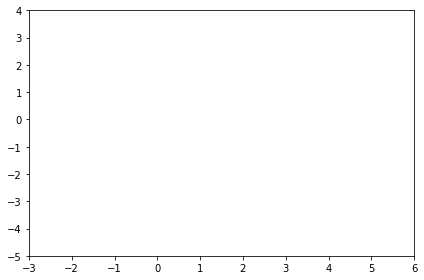

In [3]:
import numpy as np
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib.animation as ani
from matplotlib.patches import Ellipse
%matplotlib inline


# draw 95% confidence interval of multivariate normal distribution
def draw_ellipse(mu, cov, ax, **kwargs):
    var, U = np.linalg.eig(cov)
    if U[1, 0] == 0:
        angle = 0
    else:
        angle = 180. / np.pi * np.arctan(U[0, 0]/ U[1, 0])

    e = Ellipse(mu, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), 
                angle=angle, facecolor='none', **kwargs)
    ax.add_artist(e)
    return e


def make_plot(data, mu, cov, scatter_color, ax):
    artists = []
    im1 = ax.scatter(data[:,0], data[:,1], s=20, c=scatter_color, alpha=0.5)
    artists.append(im1)
    for i in range(n_cluster):
        im2 = ax.scatter(mu[i, 0], mu[i, 1], marker="x", s=50, c=colors[i])
        artists.append(im2)
        im3 = draw_ellipse(mu[i], cov[i], ax, edgecolor=colors[i])
        artists.append(im3)
    return artists


def calc_L(data, mu, cov, pi):
    L = np.zeros((len(data), len(pi)))
    for i in range(len(pi)):
        L[:,i] = pi[i] * stats.multivariate_normal(mean=mu[i], cov=cov[i]).pdf(data)
    return L


#＃# サンプルデータ作成
n_cluster = 3
z_list = np.array([0.2, 0.5, 0.3])
colors = ["r", "g", "b"]

random.seed(18)
n_sample = 500

mu_list = stats.uniform(loc=-3, scale=6).rvs(size=(3, 2))
cov_list = stats.invwishart(df=3, scale=np.eye(2)).rvs(3)

# 各サンプルをどの分布から発生させるか
lab = random.choice(n_cluster, n_sample, p = z_list)
class_count = Counter(lab)

data = []
for i in range(n_cluster):
    y = stats.multivariate_normal(mean=mu_list[i], cov=cov_list[i]).rvs(class_count[i])
    data.append(y)
    
D = np.vstack(data)  
    

#＃# EMアルゴリズム
threshold = 1e-4
fig, ax = plt.subplots()
ax.set_xlim(-3, 6)
ax.set_ylim(-5, 4)
ims = []

## mu, Sigma, piの初期化
(xmin, ymin), (xmax, ymax) = D.min(axis=0), D.max(axis=0)

random.seed(0)
mu_x = random.uniform(xmin, xmax, n_cluster)
mu_y = random.uniform(ymin, ymax, n_cluster)
mu = np.c_[mu_x, mu_y]

cov = np.tile(0.1 * np.eye(2), (n_cluster, 1, 1))
pi = random.dirichlet(1000 * np.ones(n_cluster))

## E Step 
L = calc_L(D, mu, cov, pi)

# log likelihood
loglike = np.log(L.sum(axis=1)).sum()


for step in range(50):
    loglike_prev = loglike
    
    ## E Step 
    # responsibility
    gamma = L / L.sum(axis=1, keepdims=True)

    ## plot
    artists = make_plot(D, mu, cov, gamma, ax)
    ims.append(artists) 
    
    ## M Step
    # 各クラスターの実質的なデータ数
    n_k = gamma.sum(axis=0)

    # 負担率による重み付き和
    mu = np.zeros((n_cluster, 2))
    for k in range(n_cluster):
        mu[k] = (gamma[:,k, np.newaxis] * D).sum(axis=0) / n_k[k]

    # 共分散行列
    cov = np.zeros((n_cluster, 2, 2))
    for k in range(n_cluster):
        diff = D - mu[k]
        sigma = np.dot(diff.T, gamma[:, k, np.newaxis] * diff) / n_k[k]
        cov[k] = sigma

    # 混合係数
    pi = n_k / n_sample
    
    ## calculate log likelihood
    L = calc_L(D, mu, cov, pi)
    loglike = np.log(L.sum(axis=1)).sum()

    loglike_diff = loglike - loglike_prev
    
    ## plot
    artists = make_plot(D, mu, cov, gamma, ax)
    ims.append(artists) 
    
    print("decrease of log likelihood: {0:.4f}".format(loglike_diff))
    
    if loglike_diff < threshold:
        print(f"log likelihood converged after {step} iteration")
        break
        
# アニメーションを作成する。
plt.tight_layout()
anim = ani.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000)
# anim.save('animation.gif', writer='imagemagick')

In [119]:
import numpy as np
from numpy import random
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline

In [349]:
def draw_ellipse(mu, cov, ax, **kwargs):
    var, U = np.linalg.eig(cov)
    if U[1, 0] == 0:
        angle = 0
    else:
        angle = 180. / np.pi * np.arctan(U[0, 0]/ U[1, 0])

    e = Ellipse(mu, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), 
                angle=angle, facecolor='none', **kwargs)
    ax.add_artist(e)

In [359]:
n_cluster = 3
z_list = np.array([0.2, 0.5, 0.3])
colors = ["r", "g", "b"]

# random.seed(1)
random.seed(18)

n_sample = 500

mu_list = stats.uniform(loc=-3, scale=6).rvs(size=(3, 2))
# mu_list = np.array([[2, 0], [0, 2], [-3, 1]])
cov_list = stats.invwishart(df=3, scale=np.eye(2)).rvs(3)
# cov_list = np.array([[[1.0, 0.7], [0.7, 1.0]],
#                     [[1.0, -0.8],[-0.8, 1.0]],
#                     [[1.0, 0.6],[0.6, 1.0]]])

# 各サンプルをどの分布から発生させるか
lab = random.choice(n_cluster, n_sample, p = z_list)
class_count = Counter(lab)

data = []
for i in range(n_cluster):
    y = stats.multivariate_normal(mean=mu_list[i], cov=cov_list[i]).rvs(class_count[i])
    data.append(y)

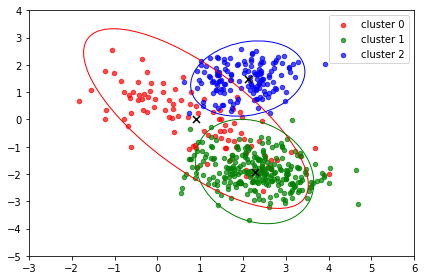

In [368]:
fig, ax = plt.subplots()
for i, y in enumerate(data):
    ax.scatter(y[:,0], y[:,1], s=20, c=colors[i], alpha=0.7, label=f'cluster {i}')
    draw_ellipse(mu_list[i], cov_list[i], ax, edgecolor=colors[i]) 
ax.scatter(mu_list[:,0], mu_list[:,1], marker='x', c='k', s=50)
ax.set_xlim(-3, 6)
ax.set_ylim(-5, 4)
ax.legend()
plt.tight_layout()
plt.savefig('gaussian_mix_labeled.png')

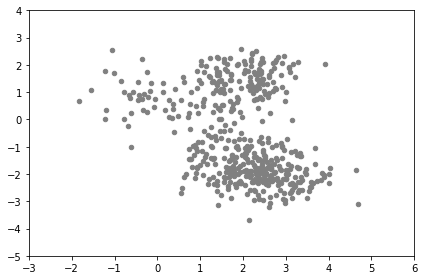

In [369]:
D = np.vstack(data)

fig, ax = plt.subplots()
ax.scatter(D[:,0], D[:,1], s=20, c="gray")
ax.set_xlim(-3, 6)
ax.set_ylim(-5, 4)
plt.tight_layout()
plt.savefig('gaussian_mix.png')

In [123]:
X = Y = np.linspace(-5, 5)
XX, YY = np.meshgrid(X, Y)

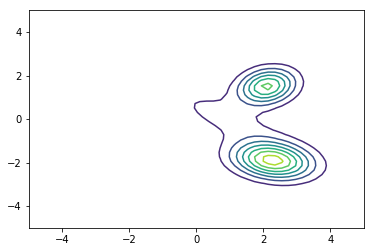

In [124]:
# 混合分布の確率密度関数
pdfs = np.zeros(len(XX.ravel()))
for i in range(n_cluster):
    pdfs += z_list[i] * stats.multivariate_normal(mean=mu_list[i], cov=cov_list[i]).pdf(list(zip(XX.ravel(), YY.ravel())))
    
ZZ = pdfs.reshape(50, 50)

plt.contour(XX, YY, ZZ)
# plt.xlim(-1, 4)
# plt.ylim(-4, 3)

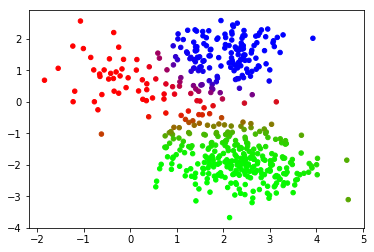

In [125]:
# 負担率
L = np.zeros((n_sample, n_cluster))
for i in range(n_cluster):
    L[:,i] = z_list[i] * stats.multivariate_normal(mean=mu_list[i], cov=cov_list[i]).pdf(D)
    
gamma = L / L.sum(axis=1)[:, np.newaxis]

# RGBで色指定
plt.scatter(D[:,0], D[:,1], s=20, c=gamma)

## EMアルゴリズム
* ステップ１：平均、分散、混合係数のパラメータをランダムに初期化
* ステップ2（Eステップ）：負担率resopnsibility（事後確率）の算出
* ステップ3(Mステップ）：尤度を最大化する平均、分散、混合係数を再計算

In [304]:
def calc_L(data, mu, cov, pi):
    L = np.zeros((len(data), len(pi)))
    for i in range(len(pi)):
        L[:,i] = pi[i] * stats.multivariate_normal(mean=mu[i], cov=cov[i]).pdf(data)
    return L


from matplotlib.patches import Ellipse
# draw 95% confidence interval of multivariate normal distribution
def draw_ellipse(mu, cov, ax, **kwargs):
    var, U = np.linalg.eig(cov)
    if U[1, 0] == 0:
        angle = 0
    else:
        angle = 180. / np.pi * np.arctan(U[0, 0]/ U[1, 0])

    e = Ellipse(mu, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), 
                angle=angle, facecolor='none', **kwargs)
    ax.add_artist(e)

def make_plot(data, mu, cov, scatter_color, ax):
    ax.scatter(data[:,0], data[:,1], s=20, c=scatter_color, alpha=0.5)
    for i in range(n_cluster):
        ax.scatter(mu[i, 0], mu[i, 1], marker="x", s=50, c=colors[i])
        draw_ellipse(mu[i], cov[i], ax, edgecolor=colors[i])

不良設定問題？

In [336]:
mu[2] = [1.43823549e-01,  1.34223313e+00]
cov = np.tile(np.eye(2), (n_cluster, 1, 1))

cov[2] = 1e-10 * np.eye(2)

L = calc_L(D, mu, cov, pi)

# log likelihood
loglike = np.log(L.sum(axis=1)).sum()
loglike

decrease of log likelihood: 1742.6027
decrease of log likelihood: 15.8193
decrease of log likelihood: 5.6987
decrease of log likelihood: 2.1909
decrease of log likelihood: 1.1473
decrease of log likelihood: 0.8206
decrease of log likelihood: 0.6550
decrease of log likelihood: 0.5250
decrease of log likelihood: 0.4121
decrease of log likelihood: 0.3181
decrease of log likelihood: 0.2442
decrease of log likelihood: 0.1889
decrease of log likelihood: 0.1488
decrease of log likelihood: 0.1207
decrease of log likelihood: 0.1013
decrease of log likelihood: 0.0883
decrease of log likelihood: 0.0795
decrease of log likelihood: 0.0738
decrease of log likelihood: 0.0700
decrease of log likelihood: 0.0675
decrease of log likelihood: 0.0659
decrease of log likelihood: 0.0647
decrease of log likelihood: 0.0637
decrease of log likelihood: 0.0629
decrease of log likelihood: 0.0621
decrease of log likelihood: 0.0612
decrease of log likelihood: 0.0602
decrease of log likelihood: 0.0591
decrease of log 

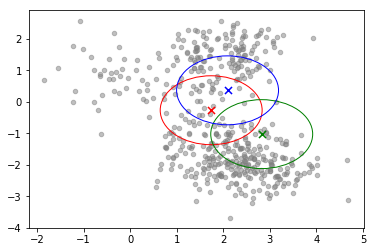

In [387]:
import matplotlib.animation as ani

threshold = 1e-3

## mu, Sigma, piの初期化
(xmin, ymin), (xmax, ymax) = D.min(axis=0), D.max(axis=0)

random.seed(0)
mu_x = random.uniform(xmin, xmax, n_cluster)
mu_y = random.uniform(ymin, ymax, n_cluster)
mu = np.c_[mu_x, mu_y]

cov = np.tile(0.2 * np.eye(2), (n_cluster, 1, 1))
pi = random.dirichlet(1000 * np.ones(n_cluster))

## plot
fig, ax = plt.subplots()
make_plot(D, mu, cov, "gray", ax)
    
## E Step 
L = calc_L(D, mu, cov, pi)

# log likelihood
loglike = np.log(L.sum(axis=1)).sum()

loglikes = [loglike]
for step in range(100):
    loglike_prev = loglike
    
    ## E Step 
    # responsibility
    gamma = L / L.sum(axis=1, keepdims=True)

    ## plot
#     fig, ax = plt.subplots()
#     make_plot(D, mu, cov, gamma, ax)
    
    ## M Step
    # 各クラスターの実質的なデータ数
    n_k = gamma.sum(axis=0)

    # 負担率による重み付き和
    mu = np.zeros((n_cluster, 2))
    for k in range(n_cluster):
        mu[k] = (gamma[:,k, np.newaxis] * D).sum(axis=0) / n_k[k]

    # 共分散行列
    cov = np.zeros((n_cluster, 2, 2))
    for k in range(n_cluster):
        diff = D - mu[k]
        sigma = np.dot(diff.T, gamma[:, k, np.newaxis] * diff) / n_k[k]
        cov[k] = sigma

    # 混合係数
    pi = n_k / n_sample
    
    ## plot
#     fig, ax = plt.subplots()
#     make_plot(D, mu, cov, "gray", ax)
    
    ## calculate log likelihood
    L = calc_L(D, mu, cov, pi)
    loglike = np.log(L.sum(axis=1)).sum()
    loglikes.append(loglike)

    loglike_diff = loglike - loglike_prev
    
    print("decrease of log likelihood: {0:.4f}".format(loglike_diff))
    
    if loglike_diff < threshold:
        print(f"log likelihood converged after {step} iteration")
        break

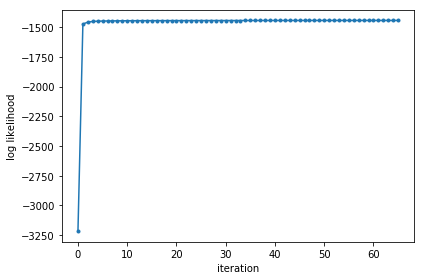

In [390]:
plt.plot(loglikes, '.-')
# plt.ylim(-1500, -1400)
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.tight_layout()
plt.savefig("loglikelihood.png")

In [403]:
from matplotlib.patches import Ellipse
# draw 95% confidence interval of multivariate normal distribution
def draw_ellipse(mu, cov, ax, **kwargs):
    var, U = np.linalg.eig(cov)
    if U[1, 0] == 0:
        angle = 0
    else:
        angle = 180. / np.pi * np.arctan(U[0, 0]/ U[1, 0])

    e = Ellipse(mu, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), 
                angle=angle, facecolor='none', **kwargs)
    ax.add_artist(e)
    return e

def make_plot(data, mu, cov, scatter_color, ax):
    artists = []
    im1 = ax.scatter(data[:,0], data[:,1], s=20, c=scatter_color, alpha=0.5)
    artists.append(im1)
    for i in range(n_cluster):
        im2 = ax.scatter(mu[i, 0], mu[i, 1], marker="x", s=50, c=colors[i])
        artists.append(im2)
        im3 = draw_ellipse(mu[i], cov[i], ax, edgecolor=colors[i])
        artists.append(im3)
    return artists

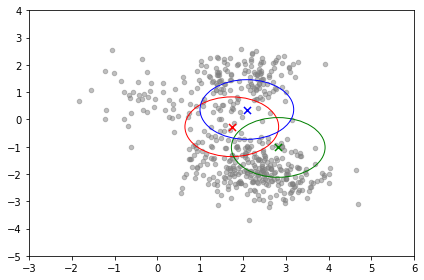

In [393]:
import matplotlib.animation as ani

threshold = 1e-4

## mu, Sigma, piの初期化
(xmin, ymin), (xmax, ymax) = D.min(axis=0), D.max(axis=0)

random.seed(0)
mu_x = random.uniform(xmin, xmax, n_cluster)
mu_y = random.uniform(ymin, ymax, n_cluster)
mu = np.c_[mu_x, mu_y]

cov = np.tile(0.2 * np.eye(2), (n_cluster, 1, 1))
pi = random.dirichlet(1000 * np.ones(n_cluster))

## plot
fig, ax = plt.subplots()
make_plot(D, mu, cov, "gray", ax)
ax.set_xlim(-3, 6)
ax.set_ylim(-5, 4)
plt.tight_layout()
plt.savefig('initial_guess.png')

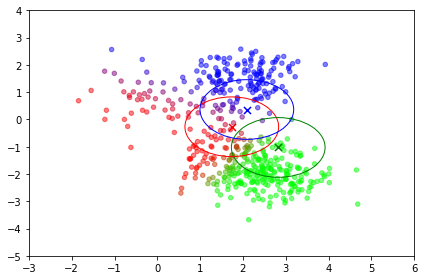

In [379]:
## E Step 
L = calc_L(D, mu, cov, pi)

# log likelihood
loglike = np.log(L.sum(axis=1)).sum()

loglikes = [loglike]
# for step in range(100):
loglike_prev = loglike

## E Step 
# responsibility
gamma = L / L.sum(axis=1, keepdims=True)

## plot
fig, ax = plt.subplots()
make_plot(D, mu, cov, gamma, ax)
ax.set_xlim(-3, 6)
ax.set_ylim(-5, 4)
plt.tight_layout()
plt.savefig('E_step.png')

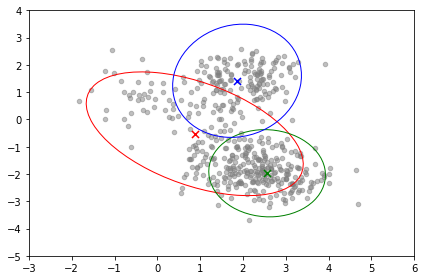

In [380]:
## M Step
# 各クラスターの実質的なデータ数
n_k = gamma.sum(axis=0)

# 負担率による重み付き和
mu = np.zeros((n_cluster, 2))
for k in range(n_cluster):
    mu[k] = (gamma[:,k, np.newaxis] * D).sum(axis=0) / n_k[k]

# 共分散行列
cov = np.zeros((n_cluster, 2, 2))
for k in range(n_cluster):
    diff = D - mu[k]
    sigma = np.dot(diff.T, gamma[:, k, np.newaxis] * diff) / n_k[k]
    cov[k] = sigma

# 混合係数
pi = n_k / n_sample
    
# plot
fig, ax = plt.subplots()
make_plot(D, mu, cov, "gray", ax)
ax.set_xlim(-3, 6)
ax.set_ylim(-5, 4)
plt.tight_layout()
plt.savefig('M_step.png')

decrease of log likelihood: 4019.4299
decrease of log likelihood: 17.1372
decrease of log likelihood: 5.2259
decrease of log likelihood: 1.8730
decrease of log likelihood: 1.0570
decrease of log likelihood: 0.8002
decrease of log likelihood: 0.6561
decrease of log likelihood: 0.5352
decrease of log likelihood: 0.4267
decrease of log likelihood: 0.3341
decrease of log likelihood: 0.2597
decrease of log likelihood: 0.2027
decrease of log likelihood: 0.1604
decrease of log likelihood: 0.1299
decrease of log likelihood: 0.1084
decrease of log likelihood: 0.0936
decrease of log likelihood: 0.0835
decrease of log likelihood: 0.0766
decrease of log likelihood: 0.0720
decrease of log likelihood: 0.0688
decrease of log likelihood: 0.0665
decrease of log likelihood: 0.0648
decrease of log likelihood: 0.0634
decrease of log likelihood: 0.0622
decrease of log likelihood: 0.0609
decrease of log likelihood: 0.0596
decrease of log likelihood: 0.0582
decrease of log likelihood: 0.0566
decrease of log 

MovieWriter imagemagick unavailable. Trying to use pillow instead.


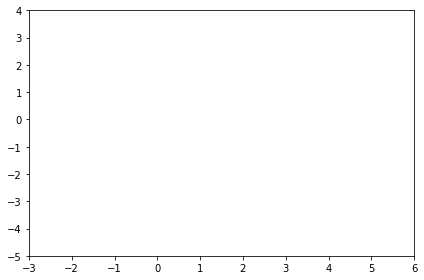

In [405]:
import matplotlib.animation as ani

threshold = 1e-4
fig, ax = plt.subplots()
ax.set_xlim(-3, 6)
ax.set_ylim(-5, 4)
ims = []

## mu, Sigma, piの初期化
(xmin, ymin), (xmax, ymax) = D.min(axis=0), D.max(axis=0)

random.seed(0)
mu_x = random.uniform(xmin, xmax, n_cluster)
mu_y = random.uniform(ymin, ymax, n_cluster)
mu = np.c_[mu_x, mu_y]

cov = np.tile(0.1 * np.eye(2), (n_cluster, 1, 1))
pi = random.dirichlet(1000 * np.ones(n_cluster))

## plot
# artists = make_plot(D, mu, cov, "gray", ax)
# ims.append(artists) 
    
## E Step 
L = calc_L(D, mu, cov, pi)

# log likelihood
loglike = np.log(L.sum(axis=1)).sum()


for step in range(50):
    loglike_prev = loglike
    
    ## E Step 
    # responsibility
    gamma = L / L.sum(axis=1, keepdims=True)

    ## plot
    artists = make_plot(D, mu, cov, gamma, ax)
    ims.append(artists) 
    
    ## M Step
    # 各クラスターの実質的なデータ数
    n_k = gamma.sum(axis=0)

    # 負担率による重み付き和
    mu = np.zeros((n_cluster, 2))
    for k in range(n_cluster):
        mu[k] = (gamma[:,k, np.newaxis] * D).sum(axis=0) / n_k[k]

    # 共分散行列
    cov = np.zeros((n_cluster, 2, 2))
    for k in range(n_cluster):
        diff = D - mu[k]
        sigma = np.dot(diff.T, gamma[:, k, np.newaxis] * diff) / n_k[k]
        cov[k] = sigma

    # 混合係数
    pi = n_k / n_sample
    
    ## calculate log likelihood
    L = calc_L(D, mu, cov, pi)
    loglike = np.log(L.sum(axis=1)).sum()

    loglike_diff = loglike - loglike_prev
    
    ## plot
    artists = make_plot(D, mu, cov, gamma, ax)
    ims.append(artists) 
    
    print("decrease of log likelihood: {0:.4f}".format(loglike_diff))
    
    if loglike_diff < threshold:
        print(f"log likelihood converged after {step} iteration")
        break
        
# アニメーションを作成する。
plt.tight_layout()
anim = ani.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000)
anim.save('animation.gif', writer='imagemagick')

### 検討用

In [489]:
threshold = 1e-4

## mu, Sigma, piの初期化
(xmin, ymin), (xmax, ymax) = D.min(axis=0), D.max(axis=0)

random.seed(0)
mu_x = random.uniform(xmin, xmax, n_cluster)
mu_y = random.uniform(ymin, ymax, n_cluster)
mu = np.c_[mu_x, mu_y]

cov = np.tile(0.1 * np.eye(2), (n_cluster, 1, 1))
pi = random.dirichlet(1000 * np.ones(n_cluster))

## E Step 
L = calc_L(D, mu, cov, pi)

# log likelihood
loglike = np.log(L.sum(axis=1)).sum()


# for step in range(200):
loglike_prev = loglike

## E Step 
# responsibility
gamma = L / L.sum(axis=1, keepdims=True)

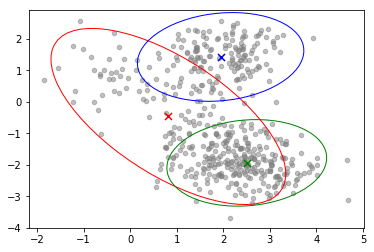

In [175]:
# 95% confidence interval
fig, ax = plt.subplots()
ims =[]
ax.scatter(D[:,0], D[:,1], s=20, c="gray", alpha=0.5)
for i in range(n_cluster):
    ax.scatter(mu[i, 0], mu[i, 1], marker="x", s=50, c=colors[i])
    draw_ellipse(mu[i], cov[i], ax, edgecolor=colors[i])

In [174]:
fig.axes[0].artists

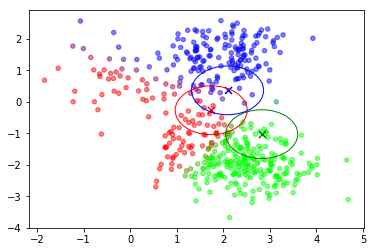

In [511]:
# 負担率を色で表現(E step)
fig, ax = plt.subplots()
ax.scatter(D[:,0], D[:,1], s=20, c=gamma, alpha=0.5)
for i in range(n_cluster):
    ax.scatter(mu[i, 0], mu[i, 1], marker="x", s=50, c=colors[i])
    draw_ellipse(mu[i], cov[i], ax, edgecolor=colors[i])

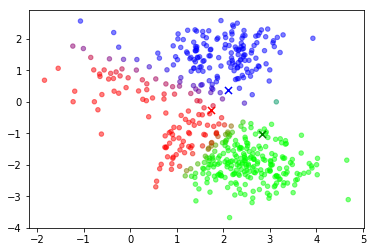

In [490]:
# 負担率を色で表現
plt.figure()
plt.scatter(D[:,0], D[:,1], s=20, c=gamma, alpha=0.5)
for i in range(n_cluster):
    plt.scatter(mu[i, 0], mu[i, 1], marker="x", s=50, c=colors[i])

In [338]:
## E Step
# 負担率
L = np.zeros((n_sample, n_cluster))
for i in range(n_cluster):
    L[:,i] = pi[i] * stats.multivariate_normal(mean=mu_init[i], cov=cov_init[i]).pdf(D)
    
gamma = L / L.sum(axis=1)[:, np.newaxis]

In [283]:
## Mステップ
# 負担率による重み付き和
mu_new = np.array([(gamma[:,i][:, np.newaxis] * D).sum(axis=0) / n_k[i] for i in range(n_cluster)])

# 共分散行列
cov_new = np.zeros((n_cluster, 2, 2))
for k in range(n_cluster):
    diff = D - mu_new[0]
    sigma = np.dot(diff.T, gamma[:,k][:, np.newaxis] * diff) / n_k[k]
    cov_new[k] = sigma
    
# 混合係数
pi_new = n_k / n_sample

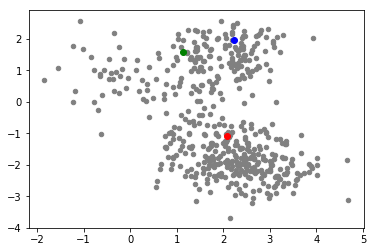

In [284]:
plt.scatter(D[:,0], D[:,1], s=20, c="gray")
for i in range(n_cluster):
    plt.scatter(mu_new[i, 0], mu_new[i, 1], c=colors[i])

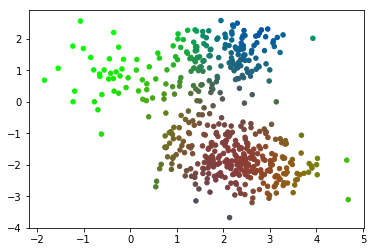

In [285]:
# 負担率
L = np.zeros((n_sample, n_cluster))
for i in range(n_cluster):
    L[:,i] = z_list[i] * stats.multivariate_normal(mean=mu_new[i], cov=cov_new[i]).pdf(D)
    
gamma = L / L.sum(axis=1)[:, np.newaxis]

# RGBで色指定
plt.scatter(D[:,0], D[:,1], s=20, c=gamma)

In [289]:
cov

array([[ 0.31833585,  0.05548478],
       [ 0.05548478,  0.29721809]])